# Initial conditions in v2 (cython) routing
- Currently, the v2 (cython) routing framework does not allow for initial flow conditions to be specified. Rather, an initial state of zero cms is assumed for all segments in the network. 
- To make v2 (cython) routing operational, we need to specify initial conditions (flow, velocity, and depth) from a restart file. 
- This notebook illustrates changes made to `mc_reach.pyx` to use specified initial conditions. 

In [1]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "network-compute-notebook",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )

    subprocess.run("pip", "install", "geopandas")
    subprocess.run("pip", "install", "netcdf4")
    subprocess.run("pip", "install", "gif")

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)

# Compile cython module, here. 
# Unique to A. Wlostowski's system requirements. 
# TODO: Create another version of this notebook for Google Colab to include in PR.

COMPILE_cython = True
if COMPILE_cython:

    subprocess.run(
        ["gfortran", "varPrecision.f90", "-c", "-o", "var_precision.o", "-O3", "-fPIC"],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "MCsingleSegStime_f2py_NOLOOP.f90",
            "-c",
            "-o",
            "mc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )

    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])


    numpy_I = "/home/awlostowski/tr/lib/python3.8/site-packages/numpy/core/include"
    py_I = "/usr/include/python3.8"
    py_lib = "/home/awlostowski/tr/lib"

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "mc_reach.pyx",
        ],
        cwd=routing_v02_dir,
    )
    
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-Wno-unused-result",
            "-Wsign-compare",
            "-DNDEBUG",
            "-g",
            "-fwrapv",
            "-O3",
            "-fno-strict-aliasing",
            "-Wall",
            "-Wstrict-prototypes",
            "-fPIC",
            "-I",
            numpy_I,
            "-I",
            py_I,
            "-c",
            "mc_reach.c",
            "-o",
            "mc_reach.o",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared",
            "-L",
            py_lib,
            "var_precision.o",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "mc_reach.o",
            "-lgfortran",
            "-o",
            "mc_reach.cpython-38-x86_64-linux-gnu.so",
        ],
        cwd=routing_v02_dir,
    )

# import scientific libraries
import time
import numpy as np
from operator import itemgetter
from itertools import chain, islice
from functools import partial
from joblib import delayed, Parallel
import random
import pandas as pd
import numpy as np
from scipy.stats import norm
import geopandas
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# network/reach utilities & routing module
import nhd_network_utilities_v02 as nnu
import nhd_io
import nhd_network
import mc_reach
import network_dl

/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/mc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/pymc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/var_precision.o


In [11]:
def sim(dx, dt, q_baseflow, q_pk, flow0, vel0, depth0, short_tstep_assumption):
    """
    
    The sim function calls the mc_reach.network_compute function for a synthetic, Y-shaped network.
    The network is single, 20 km, reach fed by two single-segment headwaters:
    
    \/       : two single segment headwater reaches accept lateral inflows
     \
      \
       \
        \     : 20 km reach split into segments of length dx
         \
          \
           \
            \
             \
    
    Lateral inflows are added to the headwater segment and routed downstream. 
    The simulation runs for 6 days, with user-specified time and space increments. 
    
    Paremeters
    ----------
    dx: int
        uniform segment length applied throughout the network (meters)
    dt: int
        simulation timestep (seconds)
    q_baseflow: int
        baseflow of lateral inflows to headwater segment (cubic meters per second)
    q_pk: int
        peak flow of gaussian lateral inflow distribution to headwater segment (cubic meters per second).
        Note: The absolute peak flow is q_baseflow + q_pk
    flow0: int
        initial flow condition of all segments in the network (cubic meters per second)
    vel0: int
        initial velocity condition of all segments in the network (meters per second)
    depth0: int
        initial depth condition of all segments in the network (meters)
    short_tstep_assumption: bool
        If true, short timestep assumption is turned ON
        If false, short timestep assumption is turned OFF
    
    Returns
    flowveldepth: pandas DataFrame
        flow, velocity, and depth data returned from mc_reach.network_compute
    flows: pandas DataFrame
        flow data only, from flowveldepth, transposed
    depth: pandas DataFrame
        depth data only, from flowveldepth, transposed
    vel: pandas DataFrame
        velocity data only, from flowveldepth, transposed
    df: pandas DataFrame
        network routing parameters
    ql: pandas DataFrame
        lateral inflows 
    ic: pandas DataFrame
        initial conditions, flow, velocity and depth
    -------
    """

    ################################################
    # Set-up model domain
    ################################################
    # SPACE
    L = 20 * (1000) # meters
    nsegs = round(L/dx)

    # TIME
    n_days = 6
    len_sim = n_days*(24*60*60) # seconds
    nts = round(len_sim/dt)

    ################################################
    # Construct synthetic network
    ################################################
    link_start = 8815967 # arbitrary linkID for the top segment of the reach
    headwaters = [8815960, 8815961]
    
    # construct linkIDs and destination linkIDs (toID)
    linkID = list(range(link_start,
                        link_start + nsegs,
                        1))
    linkID = headwaters + linkID

    headwater_to = [link_start] * len(headwaters)
    toID = list(range(link_start + 1,
                      link_start + nsegs,
                      1))
    toID.append(0)
    toID = headwater_to + toID

    # link-distance lookup - what is the physical distance associated with each segment? 
    link_distance = {}
    for i, link in enumerate(linkID[len(headwaters):],1):
        link_distance[i*dx] = link

    ################################################
    # Create model parameter set
    ################################################
    d = {'link': linkID,
          'to': toID,
          'dx': [dx] * (nsegs+len(headwaters)),
          'n': [0.028] * (nsegs+len(headwaters)),
          'ncc': [0.031] * (nsegs+len(headwaters)),
          's0': [0.0018] * (nsegs+len(headwaters)),
          'bw': [112] * (nsegs+len(headwaters)),
          'tw': [448] * (nsegs+len(headwaters)),
          'twcc': [623] * (nsegs+len(headwaters)),
          'MusK': [3600.0] * (nsegs+len(headwaters)),
          'MusX': [0.2] * (nsegs+len(headwaters)),
          'cs': [1.40] * (nsegs+len(headwaters))}
    
    df = pd.DataFrame(data=d)
    df = df.set_index('link')
    df = df.sort_index()

    # replace downstreams for terminal segments
    df = nhd_io.replace_downstreams(df, 'to', 0)

    ################################################
    # Create lateral inflow data
    #
    # A Gussian pulse of lateral inflows is applied 
    # to both headwater segments. Peak flow occurs
    # at 48 hours. The temporal variance is 2 hours. 
    ################################################
    t_pk = 2*24*(60*60)
    width = 2*(60*60)

    x = np.linspace(0,len_sim, round(len_sim/dt))
    y = norm.pdf(x,t_pk,width)
    y_scale = y * q_pk/max(y) + q_baseflow

    # construct lateral inflow series
    ql = pd.DataFrame(0, index=linkID, columns=range(round(len_sim/dt)),dtype=np.float32)
    ql.loc[headwaters,:] = y_scale
    
    ################################################
    # Create initial condition data
    #
    # Initial conditions are contained in a pandas
    # DataFrame three columns for initial flow, vel,
    # and depth. Row indices must match those in the 
    # parameter DataFrame.
    ################################################
    ic = pd.DataFrame(0, index=linkID, columns=['q','v','d'],dtype=np.float32)
    ic.loc[:,'q'] = flow0
    ic.loc[:,'d'] = depth0
    ic.loc[:,'v'] = vel0

    ################################################
    # Build network
    ################################################
    conn = nhd_network.extract_connections(df, 'to')
    rconn = nhd_network.reverse_network(conn)
    subnets = nhd_network.reachable_network(rconn, check_disjoint = False)

    # identify the segments in each subnetwork
    subreachable = nhd_network.reachable(rconn)

    # break each subnetwork into reaches
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

    tail_water = max(linkID)
    reach = subreaches[tail_water]
    r = list(filter(None, chain.from_iterable(reach)))

    ################################################
    # Simulate network routing
    ################################################
    # add a dt column to the data DataFrame
    df["dt"] = dt

    # change variables to type float32, as expected by mc_reach.compute_network
    df = df.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = df.loc[
        r, ["dt", "dx", "bw", "tw", "twcc", "n", "ncc", "cs", "s0"]
    ].sort_index()

    # create qlat dataset
    qlat_sub = ql.loc[r].sort_index()

    # compute the network routing, calculate (flow, depth, and velocity)
    results = []

    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values.astype("float32"),
            ic.values.astype("float32"), # need to add initial conditions below here, astype('float32')
            assume_short_ts=short_tstep_assumption
        )
    )

    ################################################
    # re-format simulation output
    ################################################

    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()

    # create flow DataFrame
    flows = flowveldepth.loc[:, (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    flows['Time (d)'] = ((flows.Timestep + 1) * dt)/(24*60*60)
    flows = flows.set_index('Time (d)')
    flows = flows.drop(["Timestep", "Parameter"], axis=1)
    forcing = flows.loc[:,flows.columns.min()]
    
    # create depth DataFrame
    depth = flowveldepth.loc[:, (slice(None), "d")]
    depth = depth.T.reset_index(level = [0,1])
    depth.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    depth['Time (d)'] = ((depth.Timestep + 1) * dt)/(24*60*60)
    depth = depth.set_index('Time (d)')
    depth = depth.drop(["Timestep", "Parameter"], axis=1)
    
    # create vel DataFrame
    vel = flowveldepth.loc[:, (slice(None), "v")]
    vel = vel.T.reset_index(level = [0,1])
    vel.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    vel['Time (d)'] = ((vel.Timestep + 1) * dt)/(24*60*60)
    vel = vel.set_index('Time (d)')
    vel = vel.drop(["Timestep", "Parameter"], axis=1)
    vel = vel.drop(headwaters, axis = 'columns')
    
    return flowveldepth, flows, depth, vel, df, ql, ic

## Simulate network routing
Call the `sim` function with user-specified time & space increments, lateral inflow parameters, and initial conditions. 

In [36]:
# simulate routing 
dx = 500
dt = 600
q_baseflow = 50 # cms
q_pk = 20 # cms
flow0 = 100
depth0 = 0.72
vel0 = 1.2
assume_short_timestep = False
            
flowveldepth, flow, depth, vel, df, ql, ic = sim(dx, dt, q_baseflow, q_pk, flow0, vel0, depth0, assume_short_timestep)

## Plot simulated flows

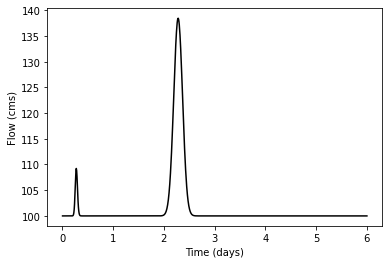

In [37]:
time = flow.index.values
q = flow.loc[:,flow.columns.max()]

plt.plot(time, q, '-',color = 'k',label = "Forcing")
plt.ylabel("Flow (cms)")
plt.xlabel("Time (days)")
plt.show()

In [38]:
# mass balance analysis

# initial system mass
mass_init = flow0 * dt * len(df) # cubic meters

# qlateral mass
mass_qlat = ql.sum().sum() * dt

# mass out
mass_out = flow.loc[:,flow.columns.max()].sum() * dt

# final system mass
mass_final = flow.loc[flow.index.max(),:].sum() * dt

# mass balance
balance = (mass_qlat - mass_out) + (mass_init - mass_final)
print(balance)

18347.4609375
